In [1]:
import sys
sys.path.append('/cellar/users/aklie/opt/AI-TAC/code')
import aitac
import torch
import torch.nn as nn

In [2]:
# Hyper parameters
num_classes = 81
batch_size = 100
learning_rate = 0.001
num_filters = 300

In [3]:
class ArchWrapper(nn.Module):
    def __init__(self, arch):
        super().__init__()
        self.arch = arch
    def forward(self, x):
        return self.arch(x)[0]

In [4]:
from eugene import models

In [5]:
# Define the model
model = ArchWrapper(aitac.ConvNet(num_classes, num_filters))

# Define a SequenceModule
module = models.SequenceModule(
    arch=model,
    input_len=250,
    output_dim=num_classes,
    task='regression',
    loss_fxn=aitac.pearson_loss,
    optimizer='adam',
    optimizer_lr=learning_rate,
    seed=1234
    
)
module

[rank: 0] Global seed set to 1234


SequenceModule(
  (arch): ArchWrapper(
    (arch): ConvNet(
      (layer1_conv): Sequential(
        (0): Conv2d(1, 300, kernel_size=(4, 19), stride=(1, 1))
        (1): ReLU()
      )
      (layer1_process): Sequential(
        (0): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1), dilation=1, ceil_mode=False)
        (1): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (layer2): Sequential(
        (0): Conv2d(300, 200, kernel_size=(1, 11), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=(0, 1), dilation=1, ceil_mode=False)
        (3): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (layer3): Sequential(
        (0): Conv2d(200, 200, kernel_size=(1, 7), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=(0, 1), dilation=1, ceil_mode=False)
        (3): BatchNorm2d(200, eps=1e-05

In [6]:
model_path = "/cellar/users/aklie/data/datasets/AI-ATAC/analysis/10Nov23/seqdata/fold_0/AI-ATAC/checkpoints/epoch=3-step=9448.ckpt"

In [7]:
model_state = torch.load(model_path, map_location=torch.device("cpu"))

In [8]:
module.load_state_dict(model_state["state_dict"])

<All keys matched successfully>

# Load some test data

In [9]:
import seqdata as sd

In [10]:
sdata = sd.open_zarr("/cellar/users/aklie/data/datasets/AI-ATAC/analysis/10Nov23/seqdata/fold_0/ai-atac_test.zarr")

In [11]:
# reshape the ohe 
sdata['ohe_seq'] = sdata['ohe_seq'].transpose('_sequence', '_ohe', 'length')

In [12]:
# Subset to 10000 random sequences
sdata = sdata.sel(_sequence=sdata._sequence.values[:10000])

# Filters

In [13]:
module.eval()

SequenceModule(
  (arch): ArchWrapper(
    (arch): ConvNet(
      (layer1_conv): Sequential(
        (0): Conv2d(1, 300, kernel_size=(4, 19), stride=(1, 1))
        (1): ReLU()
      )
      (layer1_process): Sequential(
        (0): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1), dilation=1, ceil_mode=False)
        (1): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (layer2): Sequential(
        (0): Conv2d(300, 200, kernel_size=(1, 11), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=(0, 1), dilation=1, ceil_mode=False)
        (3): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (layer3): Sequential(
        (0): Conv2d(200, 200, kernel_size=(1, 7), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=(0, 1), dilation=1, ceil_mode=False)
        (3): BatchNorm2d(200, eps=1e-05

In [40]:
interpret.attribute_sdata(
    model=module,
    sdata=sdata,
    method='InputXGradient',
)

Computing saliency on batches of size 128:   0%|          | 0/79 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [32]:
sdata["ids"].values

array(['ImmGenATAC1219.peak_3', 'ImmGenATAC1219.peak_4',
       'ImmGenATAC1219.peak_6', ..., 'ImmGenATAC1219.peak_15574',
       'ImmGenATAC1219.peak_15575', 'ImmGenATAC1219.peak_15578'],
      dtype=object)

In [30]:
sdata

<xarray.Dataset>
Dimensions:                     (_celltypes: 81, _sequence: 10000, _ohe: 4,
                                 length: 250, _length: 250,
                                 _arch.arch.layer1_conv_300_filters: 300,
                                 _arch.arch.layer1_conv_19_kernel_size: 19)
Dimensions without coordinates: _celltypes, _sequence, _ohe, length, _length,
                                _arch.arch.layer1_conv_300_filters,
                                _arch.arch.layer1_conv_19_kernel_size
Data variables: (12/16)
    cell_types                  (_celltypes) object dask.array<chunksize=(81,), meta=np.ndarray>
    chrom                       (_sequence) object dask.array<chunksize=(10000,), meta=np.ndarray>
    chromEnd                    (_sequence) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    chromStart                  (_sequence) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    fold_0                      (_sequence) bool dask.array<chunksize=(10000,), meta=np.ndarray>
    fold_1                      (_sequence) bool dask.array<chunksize=(10000,), meta=np.ndarray>
    ...                          ...
    ohe_seq                     (_sequence, _ohe, length) uint8 dask.array<chunksize=(10000, 4, 250), meta=np.ndarray>
    peak_height                 (_sequence, _celltypes) float64 dask.array<chunksize=(10000, 81), meta=np.ndarray>
    seq                         (_sequence, _length) |S1 dask.array<chunksize=(10000, 250), meta=np.ndarray>
    strand                      (_sequence) object dask.array<chunksize=(10000,), meta=np.ndarray>
    arch.arch.layer1_conv_pfms  (_arch.arch.layer1_conv_300_filters, _arch.arch.layer1_conv_19_kernel_size, _ohe) float32 ...
    GradientShap_attrs          (_sequence, _ohe, length) float32 0.0 ... 0.0
Attributes:
    length_dim:    _length
    max_jitter:    0
    sequence_dim:  _sequence

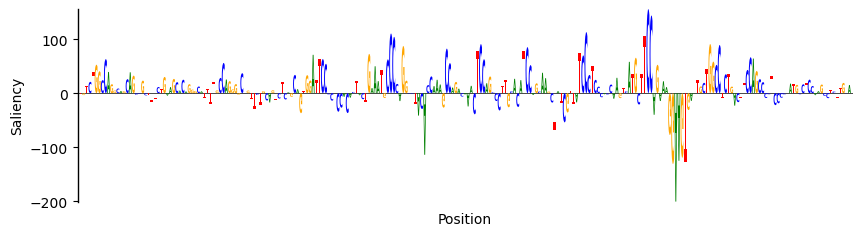

In [36]:
pl.seq_track(
    sdata,
    seq_id="ImmGenATAC1219.peak_15575",
    attrs_var="GradientShap_attrs",
    id_var="ids",
)

In [14]:
from eugene import interpret

In [15]:
models.list_available_layers(module)

['arch',
 'arch.arch',
 'arch.arch.layer1_conv',
 'arch.arch.layer1_conv.0',
 'arch.arch.layer1_conv.1',
 'arch.arch.layer1_process',
 'arch.arch.layer1_process.0',
 'arch.arch.layer1_process.1',
 'arch.arch.layer2',
 'arch.arch.layer2.0',
 'arch.arch.layer2.1',
 'arch.arch.layer2.2',
 'arch.arch.layer2.3',
 'arch.arch.layer3',
 'arch.arch.layer3.0',
 'arch.arch.layer3.1',
 'arch.arch.layer3.2',
 'arch.arch.layer3.3',
 'arch.arch.layer4',
 'arch.arch.layer4.0',
 'arch.arch.layer4.1',
 'arch.arch.layer4.2',
 'arch.arch.layer5',
 'arch.arch.layer5.0',
 'arch.arch.layer5.1',
 'arch.arch.layer5.2',
 'arch.arch.layer6',
 'arch.arch.layer6.0',
 'train_metric',
 'val_metric',
 'test_metric']

In [17]:
interpret.generate_pfms_sdata?

Signature:
interpret.generate_pfms_sdata(
    model: torch.nn.modules.module.Module,
    sdata: xarray.core.dataset.Dataset,
    layer_name: str,
    kernel_size: int,
    padding: int = 0,
    num_filters: Optional[int] = None,
    seq_var: Optional[str] = 'ohe_seq',
    activations: Optional[numpy.ndarray] = None,
    seqs: Optional[numpy.ndarray] = None,
    activation_threshold: Optional[float] = None,
    num_seqlets: int = 100,
    batch_size: Optional[int] = None,
    num_workers: Optional[int] = None,
    prefetch_factor: Optional[int] = None,
    transforms: Optional[Dict[str, Any]] = None,
    device: Optional[str] = None,
    prefix: str = '',
    suffix: str = '',
    copy: bool = False,
) -> Optional[xarray.core.dataset.Dataset]
Docstring:
Generate position frequency matrices (PFMs) from SeqData using a a given convolutional layer of a PyTorch nn.Module. 

This function wraps the `get_activators_max_seqlets` and `get_pfms` functions from the `seqexplainer` package
to gener

In [16]:
interpret.generate_pfms_sdata(
    model=module,
    sdata=sdata,
    layer_name="arch.arch.layer1_conv",
    kernel_size=19,
)

Getting activations on batches of size 128:   0%|          | 0/79 [00:00<?, ?it/s]

Using all 300 filters.


Getting filter activators for 300 filters:   0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
sdata

<xarray.Dataset>
Dimensions:      (_celltypes: 81, _sequence: 62888, _ohe: 4, length: 250,
                  _length: 250)
Dimensions without coordinates: _celltypes, _sequence, _ohe, length, _length
Data variables: (12/14)
    cell_types   (_celltypes) object dask.array<chunksize=(81,), meta=np.ndarray>
    chrom        (_sequence) object dask.array<chunksize=(31444,), meta=np.ndarray>
    chromEnd     (_sequence) int64 dask.array<chunksize=(62888,), meta=np.ndarray>
    chromStart   (_sequence) int64 dask.array<chunksize=(62888,), meta=np.ndarray>
    fold_0       (_sequence) bool dask.array<chunksize=(62888,), meta=np.ndarray>
    fold_1       (_sequence) bool dask.array<chunksize=(62888,), meta=np.ndarray>
    ...           ...
    fold_4       (_sequence) bool dask.array<chunksize=(62888,), meta=np.ndarray>
    ids          (_sequence) object dask.array<chunksize=(31444,), meta=np.ndarray>
    ohe_seq      (_sequence, _ohe, length) uint8 dask.array<chunksize=(62888, 4, 250), meta=np.ndarray>
    peak_height  (_sequence, _celltypes) float64 dask.array<chunksize=(62888, 81), meta=np.ndarray>
    seq          (_sequence, _length) |S1 dask.array<chunksize=(62888, 250), meta=np.ndarray>
    strand       (_sequence) object dask.array<chunksize=(31444,), meta=np.ndarray>
Attributes:
    length_dim:    _length
    max_jitter:    0
    sequence_dim:  _sequence

In [18]:
from eugene import plot as pl

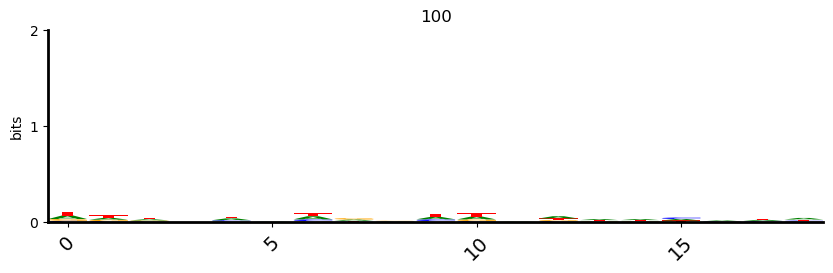

In [23]:
pl.filter_viz(
    sdata,
    filter_num=100,
    pfms_var="arch.arch.layer1_conv_pfms",
)

In [21]:
sdata["arch.arch.layer1_conv_pfms"]

<xarray.DataArray 'arch.arch.layer1_conv_pfms' (
                                                _arch.arch.layer1_conv_300_filters: 300,
                                                _arch.arch.layer1_conv_19_kernel_size: 19,
                                                _ohe: 4)>
array([[[25., 29., 26., 20.],
        [26., 23., 25., 26.],
        [27., 19., 27., 27.],
        ...,
        [28., 22., 27., 23.],
        [34., 21., 22., 23.],
        [24., 27., 21., 28.]],

       [[24., 31., 15., 30.],
        [22., 25., 21., 32.],
        [21., 21., 23., 35.],
        ...,
        [26., 18., 25., 31.],
        [22., 22., 22., 34.],
        [20., 26., 22., 32.]],

       [[19., 20., 29., 32.],
        [33., 17., 26., 24.],
        [26., 26., 31., 17.],
        ...,
...
        ...,
        [29., 23., 17., 31.],
        [28., 26., 19., 27.],
        [27., 19., 22., 32.]],

       [[24., 22., 31., 23.],
        [27., 26., 28., 19.],
        [31., 27., 18., 24.],
        ...,
        [23., 23., 35., 19.],
        [32., 25., 22., 21.],
        [34., 17., 21., 28.]],

       [[25., 17., 36., 22.],
        [21., 27., 19., 33.],
        [21., 26., 20., 33.],
        ...,
        [31., 21., 15., 33.],
        [33., 16., 25., 26.],
        [22., 26., 24., 28.]]], dtype=float32)
Dimensions without coordinates: _arch.arch.layer1_conv_300_filters,
                                _arch.arch.layer1_conv_19_kernel_size, _ohe